In [29]:
import random
import torch
random.seed(0x1337_b00b)

# Context length -> How many characters we take to predict the next
block_size = 3

class Dataset:
    def __init__(self):
        with open('names.txt', 'r') as f:
            names = f.read().split('\n')
        self.names = names

        self.build_vocab()

        # Shuffle names in place
        random.shuffle(self.names)
        # Training set and dev/validation set last index
        train_set_idx = int(0.8 * len(names))
        validation_idx = int(0.9 * len(names))
        
        self.X, self.Y = {}, {}
        self.X["train"], self.Y["train"] = self.build_dataset(self.names[:train_set_idx])
        self.X["valid"], self.Y["valid"] = self.build_dataset(self.names[train_set_idx:validation_idx])
        self.X["test"], self.Y["test"] = self.build_dataset(self.names[validation_idx:])
        

    def build_vocab(self):
        # Build vocabulary
        vocab = []
        for name in self.names:
            vocab += name
        self.vocab = sorted(set(vocab))
        
        # Build mapping from letter to integer id and for id to letter
        self.itos = { i+1:l for i, l in enumerate(self.vocab)}
        # Additional `point` at index 0
        self.itos[0] = '.'
        self.stoi = { l:i for i, l in self.itos.items()}
                

    def build_dataset(self, words):
        global block_size
        # Inputs
        X = []
        # Targets
        Y = []
        
        # For each name
        for word in words:
            # The start is an empty new context (which contains our designed dot special character)
            context = [0] * block_size
            # For each character in the name (adding dot as a stopping token)
            for ch in word + '.':
                # We add the current context and as an input to the dataset
                X.append(context)
                # Get the index of the current character and add it as a target for a potential
                # generated new character that could follow this context
                idx_ch = self.stoi[ch]
                Y.append(idx_ch)
                # Slide the context window and add the new character to it
                context = context[1:] + [idx_ch]
    
        X = torch.Tensor(X).long()
        Y = torch.Tensor(Y).long()
        return (X, Y)


    def dataset_demo(self, split, count = 10):
        for i, p in zip(self.X[split][:count], self.Y[split][:count]):
            print([self.itos[c.item()] for c in i], "-->", self.itos[p.item()])

In [36]:
d = Dataset()
print("Train examples")
d.dataset_demo("train")
print("Valid examples")
d.dataset_demo("valid")
print("Test examples")
d.dataset_demo("test")

Train examples
['.', '.', '.'] --> t
['.', '.', 't'] --> e
['.', 't', 'e'] --> n
['t', 'e', 'n'] --> s
['e', 'n', 's'] --> l
['n', 's', 'l'] --> e
['s', 'l', 'e'] --> y
['l', 'e', 'y'] --> .
['.', '.', '.'] --> k
['.', '.', 'k'] --> e
Valid examples
['.', '.', '.'] --> k
['.', '.', 'k'] --> e
['.', 'k', 'e'] --> e
['k', 'e', 'e'] --> g
['e', 'e', 'g'] --> e
['e', 'g', 'e'] --> n
['g', 'e', 'n'] --> .
['.', '.', '.'] --> l
['.', '.', 'l'] --> o
['.', 'l', 'o'] --> l
Test examples
['.', '.', '.'] --> d
['.', '.', 'd'] --> a
['.', 'd', 'a'] --> x
['d', 'a', 'x'] --> o
['a', 'x', 'o'] --> n
['x', 'o', 'n'] --> .
['.', '.', '.'] --> a
['.', '.', 'a'] --> o
['.', 'a', 'o'] --> i
['a', 'o', 'i'] --> .


In [156]:
# Parameters setup
from torch.nn import functional as F

emb_size = 10
g = torch.Generator().manual_seed(0x1337_b00b)
# Create the embedding
C = torch.randn((27, emb_size), generator=g)

# Initializing the model parameters
# First layer
# We scale the weights to control what is the standard deviation. We set it
# according to a tanh gain (5/3) and the fan_in (square root of the input size).
# source is the kaimin paper initialisation and torch docs
tanh_gain = 5/3
n_hidden = 200
fan_in = (block_size * emb_size) ** 0.5
W1 = torch.randn((block_size * emb_size, n_hidden), generator=g) * (tanh_gain / fan_in) # 0.3
# We multiply by 0.01 to make sure the bias is not high and gives us a
# uniform distribution as in layer 2
# Because we are computing the batch norm bias, this is not very useful and is replaced
# by the batch normalisation bias.
# b1 = torch.randn(n_hidden, generator=g) * 0.01
# Second layer
# We multiply by 0.01 (or a small scalar) in order to reduce and more uniformly
# distribute the weights for the first training pass and loss calculation, such that
# the logits that we get at the end of the network given roughly the same probability
# to any of the characters. This is the same concept as the first layer but with a
# instinctive value
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
# We multiply by zero to make sure intialization give uniform distribution to the logits
b2 = torch.randn(27, generator=g) * 0

# Parameters to allow the batch normalisation to scale and shift the uniform gaussian
# of a neuron's inputs in a batch,
# such that it allows the backpropagation step to optimise the neuron's shape because
# the neuron is modified with these 2 values which become parameters and have
# gradients computed as well and are optimised
batch_norm_gain = torch.ones((1, n_hidden))
batch_norm_bias = torch.zeros((1, n_hidden))

# Initialize the mean and the std that will be accumulating the mean and the standard
# deviation of batch normalisation at each training step in order to later be used in
# production when we are feeding a single example without a batch
# Because preactivations are standard gaussian we expect the mean to be close to zero
# and the std to be close to one.
hpreact_mean_final = torch.zeros((1, n_hidden))
hpreact_std_final = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]

for p in parameters:
    p.requires_grad = True

param_count = sum(p.nelement() for p in parameters)

In [157]:
losses = []
steps = []

In [158]:
# Batch of 32 examples
hpreact.shape

torch.Size([32, 200])

In [159]:
# Compute the mean over all the values across the batch
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [160]:
# Compute the standard deviation over all the values across the batch
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [161]:
# Training loop
max_steps = 200000
for idx in range(max_steps):
    # Minibatch construction
    # Sample indexes from X (minibatch of 32 examples)
    idxs = torch.randint(0, d.X["train"].shape[0], (32,))
    
    # Forward pass, only with the minibatch
    emb = C[d.X["train"][idxs]]
    # Compute the preactivation of the first hidden layer
    hpreact = emb.view(emb.shape[0], block_size * emb_size) @ W1 # + b1

    # Compute the mean and the std for the current batch
    hpreact_mean_running_idx = hpreact.mean(0, keepdim=True)
    hpreact_std_running_idx = hpreact.std(0, keepdim=True)
    # Batch normalisation, before activation, to make every neuron uniform gaussian
    # across/on these 32 examples (the entire batch)
    hpreact = (hpreact - hpreact_mean_running_idx) / hpreact_std_running_idx
    # Scale and shift this normalisation such that during the backpropagation step
    # the network will be able to tweak and update this neuron by the means of the
    # operations on this neuron using the batch_norm gain and bias
    hpreact = batch_norm_gain * hpreact + batch_norm_bias

    # Update the final mean and std according to the current ones. These values are
    # not parameters of the network and are updated to the side with the following
    # operations. As such, we instruct torch to not bother with the gradient in the back
    with torch.no_grad():
        hpreact_mean_final = 0.999 * hpreact_mean_final + 0.001 * hpreact_mean_running_idx
        hpreact_std_final = 0.999 * hpreact_std_final + 0.001 * hpreact_std_running_idx

    # Activate with tanh
    h = torch.tanh(hpreact)
    # Compute the logits -> the values of the last preactivation before the probabilities
    logits = h @ W2 + b2 # log-counts
    # Compute the loss
    loss = F.cross_entropy(logits, d.Y["train"][idxs])
    #print(loss.item())
    # Reset the gradients
    for p in parameters:
        p.grad = None
    # Compute the backward pass
    loss.backward()
    # Gradually increase the learning rate in each step
    # lr = lrs[idx]
    lr = 0.1 if idx < 100000 else 0.01
    # Update / nudge the value in the direction of the gradietn
    for p in parameters:
        p.data += -lr * p.grad

    # Track progress
    # lrs_used.append(lr_exponents[idx])
    steps.append(idx)
    # Each 10k steps print the progress of the loss
    if idx % 10000 == 0:
        print(f"{idx:6d} / {max_steps:6d} -> {loss.item():.4f}")
    losses.append(loss.log10().item())

loss

     0 / 200000 -> 3.2960
 10000 / 200000 -> 2.2551
 20000 / 200000 -> 2.2529
 30000 / 200000 -> 2.5299
 40000 / 200000 -> 2.1929
 50000 / 200000 -> 2.2374
 60000 / 200000 -> 2.2158
 70000 / 200000 -> 2.1169
 80000 / 200000 -> 2.5864
 90000 / 200000 -> 2.2014
100000 / 200000 -> 2.0870
110000 / 200000 -> 2.0048
120000 / 200000 -> 1.9247
130000 / 200000 -> 2.3147
140000 / 200000 -> 1.9934
150000 / 200000 -> 2.2063
160000 / 200000 -> 1.7875
170000 / 200000 -> 2.0876
180000 / 200000 -> 1.7015
190000 / 200000 -> 2.2761


tensor(1.9166, grad_fn=<NllLossBackward0>)

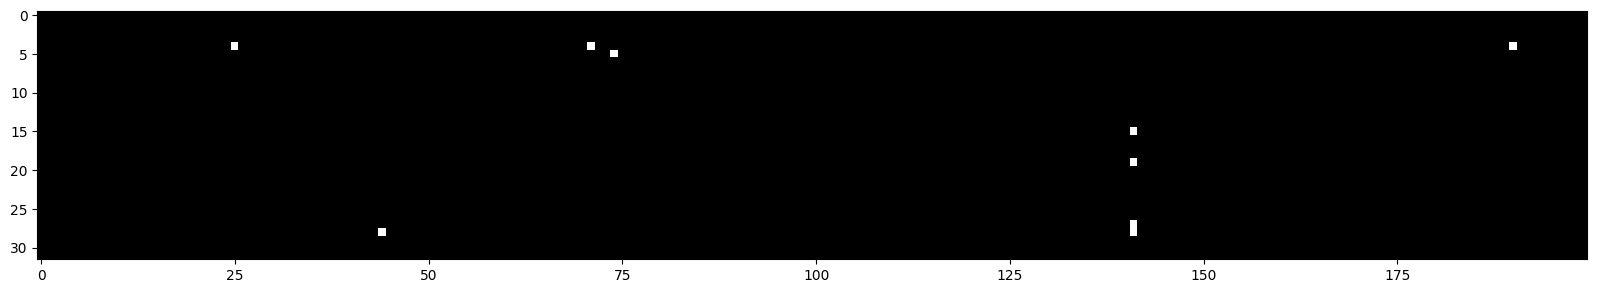

In [110]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([  1.,   4.,   2.,   4.,  13.,   5.,  17.,  35.,  27.,  48.,  82.,
         82., 125., 156., 171., 203., 268., 294., 297., 340., 334., 332.,
        372., 351., 345., 353., 342., 292., 281., 245., 189., 187., 161.,
        121.,  92.,  73.,  62.,  24.,  28.,   8.,  16.,   3.,   5.,   3.,
          1.,   4.,   1.,   0.,   0.,   1.]),
 array([-3.34969091e+00, -3.20391526e+00, -3.05813961e+00, -2.91236396e+00,
        -2.76658831e+00, -2.62081265e+00, -2.47503700e+00, -2.32926135e+00,
        -2.18348570e+00, -2.03771005e+00, -1.89193439e+00, -1.74615874e+00,
        -1.60038309e+00, -1.45460744e+00, -1.30883179e+00, -1.16305614e+00,
        -1.01728048e+00, -8.71504831e-01, -7.25729179e-01, -5.79953527e-01,
        -4.34177876e-01, -2.88402224e-01, -1.42626572e-01,  3.14908028e-03,
         1.48924732e-01,  2.94700384e-01,  4.40476036e-01,  5.86251688e-01,
         7.32027340e-01,  8.77802992e-01,  1.02357864e+00,  1.16935430e+00,
         1.31512995e+00,  1.46090560e+00,  1.60668

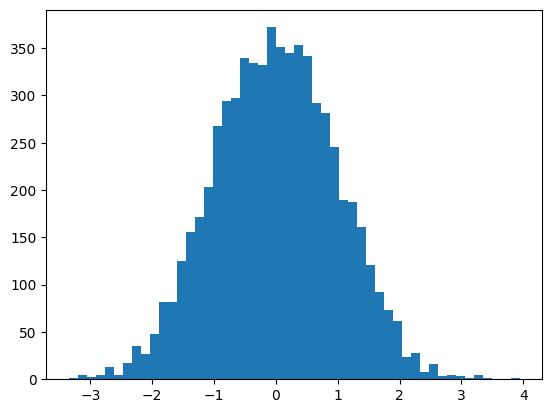

In [130]:
# After batch normalisation, each neuron is uniform gaussian across
# the entire batch (in our case 32)
plt.hist(hpreact.view(-1).tolist(), bins=50)

(array([ 70., 125., 127., 131., 147., 125., 123., 129., 146., 124., 141.,
        131., 110., 136., 100., 152., 100., 111., 113., 125., 119., 120.,
        129., 111., 107., 140., 112., 141., 132., 144., 124., 110., 138.,
        148., 135., 142., 115., 139., 128., 142., 129., 141., 153., 151.,
        161., 135., 133., 139., 127.,  89.]),
 array([-0.99520379, -0.95533929, -0.9154748 , -0.8756103 , -0.8357458 ,
        -0.7958813 , -0.7560168 , -0.7161523 , -0.67628781, -0.63642331,
        -0.59655881, -0.55669431, -0.51682981, -0.47696531, -0.43710082,
        -0.39723632, -0.35737182, -0.31750732, -0.27764282, -0.23777832,
        -0.19791383, -0.15804933, -0.11818483, -0.07832033, -0.03845583,
         0.00140867,  0.04127316,  0.08113766,  0.12100216,  0.16086666,
         0.20073116,  0.24059566,  0.28046016,  0.32032465,  0.36018915,
         0.40005365,  0.43991815,  0.47978265,  0.51964715,  0.55951164,
         0.59937614,  0.63924064,  0.67910514,  0.71896964,  0.75883414,
 

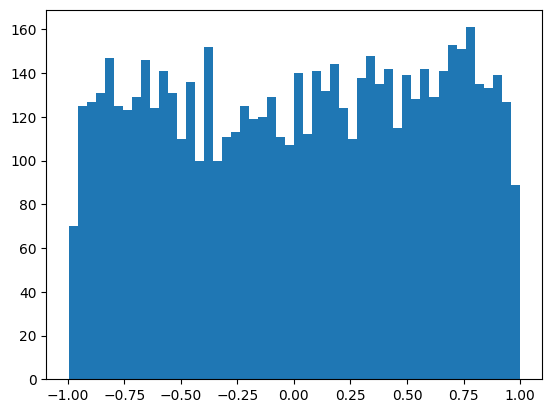

In [111]:
# Vanishing gradient (when tanh is in the flat tails of 1.0 an -1.0)
plt.hist(h.view(-1).tolist(), bins=50)

(array([  1.,   2.,   1.,   2.,   7.,   7.,  20.,  17.,  30.,  39.,  55.,
         61., 106., 111., 148., 190., 202., 252., 308., 282., 362., 362.,
        382., 386., 427., 402., 389., 306., 281., 255., 233., 186., 138.,
        111.,  91.,  52.,  76.,  30.,  13.,  17.,  30.,  11.,   9.,   5.,
          1.,   0.,   0.,   1.,   1.,   2.]),
 array([-3.01533675, -2.88585619, -2.75637564, -2.62689508, -2.49741452,
        -2.36793396, -2.23845341, -2.10897285, -1.97949229, -1.85001173,
        -1.72053118, -1.59105062, -1.46157006, -1.33208951, -1.20260895,
        -1.07312839, -0.94364783, -0.81416728, -0.68468672, -0.55520616,
        -0.4257256 , -0.29624505, -0.16676449, -0.03728393,  0.09219663,
         0.22167718,  0.35115774,  0.4806383 ,  0.61011886,  0.73959941,
         0.86907997,  0.99856053,  1.12804109,  1.25752164,  1.3870022 ,
         1.51648276,  1.64596332,  1.77544387,  1.90492443,  2.03440499,
         2.16388555,  2.2933661 ,  2.42284666,  2.55232722,  2.68180778,
 

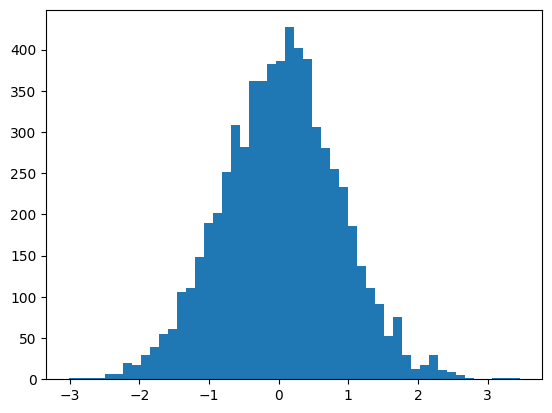

In [112]:
plt.hist(hpreact.view(-1).tolist(), bins=50)

In [146]:
# calibrate the batch norm at the end of training

# This is because during training, one of the layers computes batch normalisation
# over the number of inputs in a batch. In production, only a single instance
# will be fed forward, without a batch. As such we need to simulate the batch.
# We will do this, at the end of the training by computing a single batch normalisation
# over the entire training set that we will use in production along with the single input
with torch.no_grad():
    # Embedding over the entire training set
    emb = C[d.X['train']]
    hpreact = emb.view(emb.shape[0], 3*emb_size) @ W1 + b1
    batch_norm_mean = hpreact.mean(0, keepdim=True)
    batch_norm_std = hpreact.std(0, keepdim=True)

In [162]:
@torch.no_grad()
def compute_loss(split='train'):
    # Loss over the entire training set
    emb = C[d.X[split]]
    hpreact = emb.view(emb.shape[0], 3*emb_size) @ W1 # + b1 
    # Batch normalisation, before activation, to make every neuron uniform gaussian
    # across/on these 32 examples
    hpreact = (hpreact - hpreact_mean_final) / hpreact_std_final
    # Scale and shift this normalisation such that during the backpropagation step
    # the network will be able to tweak and update this neuron by the means of the
    # operations on this neuron using the batch_norm gain and bias
    hpreact = batch_norm_gain * hpreact + batch_norm_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # log-counts
    # Compute the loss
    loss = F.cross_entropy(logits, d.Y[split])
    
    print(f"{split}, {loss}")

compute_loss()
compute_loss('valid')

train, 2.067837715148926
valid, 2.110138177871704


In [114]:
# After fixing 2nd layer (softmax)
# train, 2.0383141040802
# valid, 2.121753454208374

# After fixing 1st layer (tanh)
# train, 2.0427069664001465
# valid, 2.1027092933654785

In [163]:
# Sampling from the model

for i in range(20):
    # Storage for the characters
    out = []
    # initial context
    context = [0] * block_size
    while True:
        emb = C[context]
        hpreact = emb.view(1, block_size * emb_size) @ W1
        hpreact = (hpreact - hpreact_mean_final) / hpreact_std_final
        h = torch.tanh(hpreact) #+ b1)
        # todo: add the batch norm step
        logits = h @ W2 + b2 # log-counts
        probs = F.softmax(logits, dim=1)
        # Sample from the probabilities
        idx = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if idx == 0:
            break
    
    print(''.join([d.itos[o] for o in out]))

quaniah.
dgwistyridvir.
aftorystylyn.
jven.
jaaqucalyr.
emarhylton.
wibel.
frante.
parcenyheus.
reyriaw.
lyny.
cipperrich.
arlin.
huzaanakalonnahnan.
zir.
concerevledent.
kieb.
chulki.
moiorah.
gund.


In [281]:
# Structuring the code
import torch


g = torch.Generator().manual_seed(0x1337_b00b)

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        kaimin_scaling = fan_in**0.5
        self.weights = torch.randn((fan_in, fan_out), generator=g) / kaimin_scaling
        if bias:
            # Bias initializing with zeros or small floats?
            self.bias = torch.zeros(fan_out)
            # self.bias = torch.rand(fan_out, generator=g) * 0.1
        else:
            self.bias = None


    def __call__(self, x_in):
        self.out = x_in @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out


    def parameters(self):
        params = [self.weights]
        if self.bias is not None:
            params += [self.bias]
        return params


class BatchNorm1d:
    def __init__(self, size, eps=1e-05, momentum=0.1):
        """Batch normalization layers defined accoding to the paper with the same name
        and torch docs

        Args:
            size: size of the batch and implictily this layer
            eps: a small variable to control that we are not dividing by zero
            momentum: The amount that each training iteration affects the final running
                mean and std used in model inference at production time. 
        """
        self.size = size
        # Controls if we are using the running mean and std when inferencing (in prod)
        # or we are computing it from the batch (training)
        self.training = True
        # Training parameters that get updated by the backward pass
        self.gamma = torch.ones(size)
        self.beta = torch.zeros(size)
        # Extra variables used to control the behaviour of the normalisation
        self.eps = eps
        self.momentum = momentum
        # Buffers (torch naming) that are not part of the backward pass and training
        self.running_mean = torch.zeros((1, size))
        self.running_std = torch.ones((1, size))


    def __call__(self, x_in):
        # Compute the mean and the std for the input
        if self.training:
            in_mean = x_in.mean(0, keepdim=True)
            in_std = x_in.std(0, keepdim=True)
        else:
            in_mean = self.running_mean
            in_std = self.running_std

        # Normalize the layer
        norm = (x_in - in_mean) / torch.sqrt(in_std + self.eps)
        # Compute the batch norm
        self.out = self.gamma * norm + self.beta

        # If we are training, we need to update the running mean and std
        if self.training:
            with torch.no_grad():
                self.running_mean = (1.-self.momentum) * self.running_mean \
                    + self.momentum * in_mean
                self.running_std = (1.-self.momentum) * self.running_std \
                    + self.momentum * in_std
        
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    
    def parameters(self):
        return []
    

In [282]:
vocab_size = 27
emb_size = 10
n_hidden = 100

C = torch.randn((vocab_size, emb_size), generator=g)

layers_without_batch_norm = [
    Linear(emb_size * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

layers_with_batch_norm = [
    Linear(emb_size * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]
layers = layers_with_batch_norm

with torch.no_grad():
    # Make last layer less confident by scaling down the weights
    # layers[-1].weights *= 0.1
    # When we have BatchNorm1d as the last layer ,we need to scale the gamma because
    # we do not have weigths, but gamma effectively acts like weights
    layers[-1].gamma *= 0.1
    # For every other preactivation layer, apply a tanh gain, similar to kaimin init
    for l in layers[:-1]:
        if isinstance(l, Linear):
            # This fights the squashing over the layers done by tanh 
            l.weights *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print("Number of parameters: ", sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

Number of parameters:  47551


In [283]:
max_steps = 200000
update_to_data_ratio = []
for idx in range(max_steps):
    # Minibatch construction
    # Sample indexes from X (minibatch of 32 examples)
    idxs = torch.randint(0, d.X["train"].shape[0], (32,))
    
    # Forward pass, only with the minibatch
    emb = C[d.X["train"][idxs]]
    # Transpose the input to match the first layer
    x_in = emb.view(emb.shape[0], block_size * emb_size)

    for layer in layers:
        x_in = layer(x_in)   
    # Compute the loss
    loss = F.cross_entropy(x_in, d.Y["train"][idxs])
    # Reset the gradients
    for p in parameters:
        p.grad = None

    # This makes the backward pass also populate the gradient for the `out` variables
    for layer in layers:
        layer.out.retain_grad()
    # Compute the backward pass
    loss.backward()

    # Gradually increase the learning rate in each step
    # lr = lrs[idx]
    lr = 0.1 if idx < 100000 else 0.01
    # Update / nudge the value in the direction of the gradietn
    for p in parameters:
        p.data += -lr * p.grad

    # Track progress
    # lrs_used.append(lr_exponents[idx])
    steps.append(idx)
    # Each 10k steps print the progress of the loss
    if idx % 10000 == 0:
        print(f"{idx:6d} / {max_steps:6d} -> {loss.item():.4f}")
    losses.append(loss.log10().item())

    with torch.no_grad():
        ud = [(lr * p.grad.std() / p.std()).log10().item() for p in parameters]
        update_to_data_ratio.append(ud)

    if idx >= 1000:
        break

loss

     0 / 200000 -> 3.2878


tensor(3.0087, grad_fn=<NllLossBackward0>)

layer Tanh, mean:  -0.00, std: 0.68, saturation 7.97
layer Tanh, mean:  +0.00, std: 0.65, saturation 4.34
layer Tanh, mean:  -0.01, std: 0.67, saturation 4.50
layer Tanh, mean:  +0.01, std: 0.68, saturation 3.97
layer Tanh, mean:  +0.00, std: 0.68, saturation 4.09


Text(0.5, 1.0, 'activation distribution')

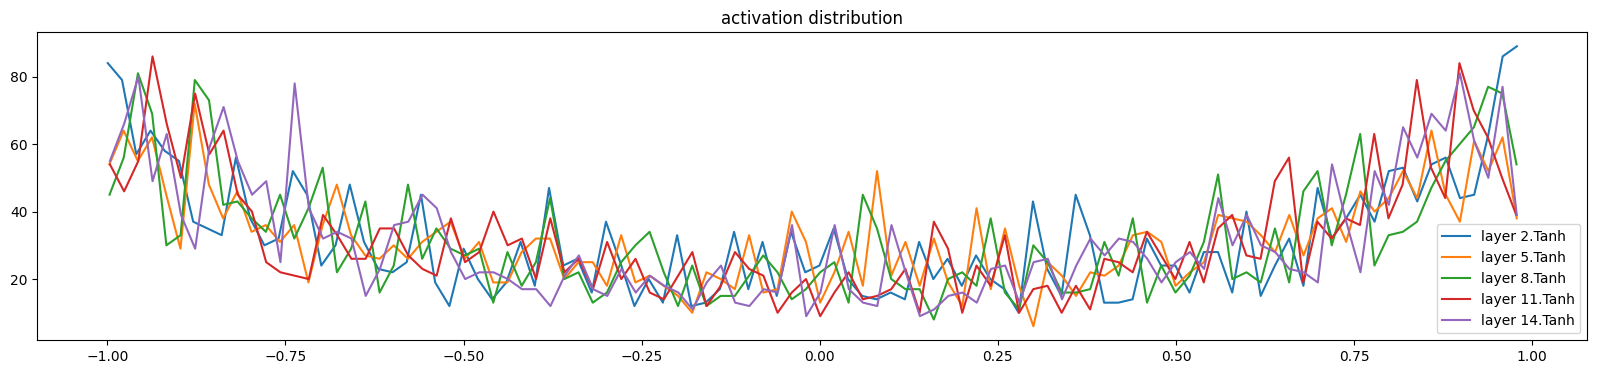

In [284]:
# Visualize histogram
plt.figure(figsize=(20, 4))
legends = []

# Alternatively we can call detach on hx and hy
with torch.no_grad():
    # Iterate over all tanh activation layers
    for idx, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            act = layer.out
            layer_name = layer.__class__.__name__
            # Saturation is how many values are on the plateau of the tanh
            saturation = (act.abs() > 0.97).float().mean() * 100
            print("layer %s, mean:  %+.2f, std: %.2f, saturation %.2f" % (layer_name, act.mean(), act.std(), saturation))
            hy, hx = torch.histogram(act, density=False)
            plt.plot(hx[:-1].numpy(), hy.numpy())
            legends.append(f'layer {idx}.{layer_name}')

plt.legend(legends)
plt.title("activation distribution")


        

layer Tanh, mean:  -0.00, std: 3.227076e-03
layer Tanh, mean:  -0.00, std: 2.982941e-03
layer Tanh, mean:  -0.00, std: 2.781474e-03
layer Tanh, mean:  +0.00, std: 2.684259e-03
layer Tanh, mean:  -0.00, std: 2.238717e-03


Text(0.5, 1.0, 'gradient distribution')

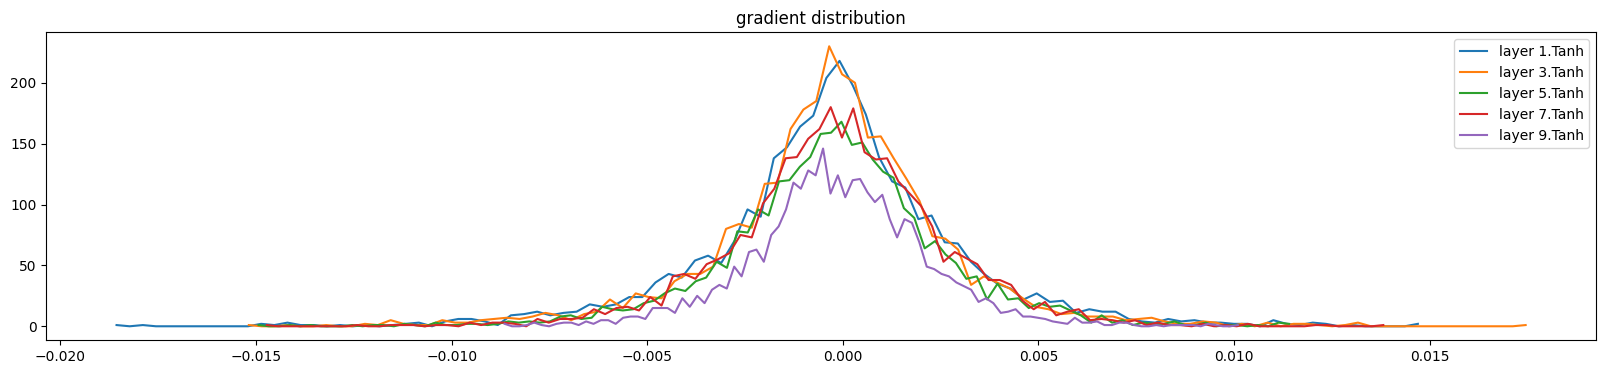

In [262]:
# Visualize histogram
plt.figure(figsize=(20, 4))
legends = []

with torch.no_grad():
    # Alternatively we can call detach on hx and hy
    # Iterate over all tanh activation layers
    for idx, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            act = layer.out.grad
            layer_name = layer.__class__.__name__
            print("layer %s, mean:  %+.2f, std: %e" % (layer_name, act.mean(), act.std()))
            hy, hx = torch.histogram(act, density=False)
            plt.plot(hx[:-1].numpy(), hy.numpy())
            legends.append(f'layer {idx}.{layer_name}')

plt.legend(legends)
plt.title("gradient distribution")

weight (27, 10), mean:  +0.000193, std: 1.282060e-02, grad/data ratio: 1.313368e-02
weight (30, 100), mean:  +0.000003, std: 1.034859e-02, grad/data ratio: 3.429322e-02
weight (100, 100), mean:  +0.000045, std: 8.113197e-03, grad/data ratio: 4.857139e-02
weight (100, 100), mean:  -0.000064, std: 6.657307e-03, grad/data ratio: 3.956622e-02
weight (100, 100), mean:  -0.000137, std: 6.233252e-03, grad/data ratio: 3.750601e-02
weight (100, 100), mean:  +0.000129, std: 5.204966e-03, grad/data ratio: 3.078223e-02
weight (100, 27), mean:  +0.000000, std: 2.144349e-02, grad/data ratio: 3.104643e-01


Text(0.5, 1.0, 'parameters gradients')

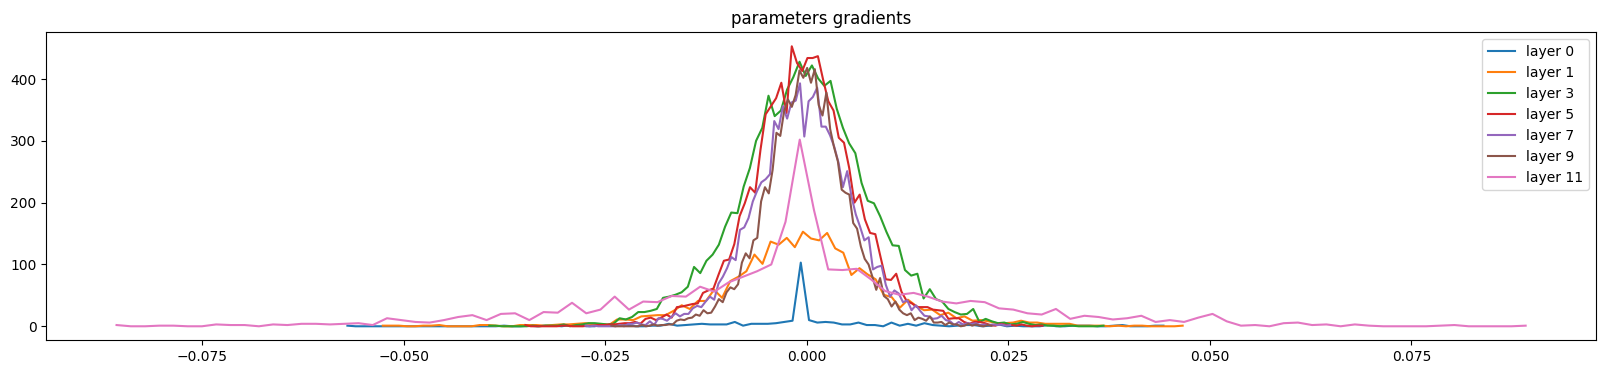

In [263]:
plt.figure(figsize=(20, 4))
legends = []

with torch.no_grad():
    # Alternatively we can call detach on hx and hy
    # Iterate over all tanh activation layers
    for idx, param in enumerate(parameters):
        grad = param.grad
        # only plot the weights, which are 2 dimensional
        if param.ndim == 2:
            print("weight %s, mean:  %+f, std: %e, grad/data ratio: %e" % (tuple(grad.shape), grad.mean(), grad.std(), grad.std() / param.std()))
            hy, hx = torch.histogram(grad, density=False)
            plt.plot(hx[:-1].numpy(), hy.numpy())
            legends.append(f'layer {idx}')

plt.legend(legends)
plt.title("weigths data & gradients")

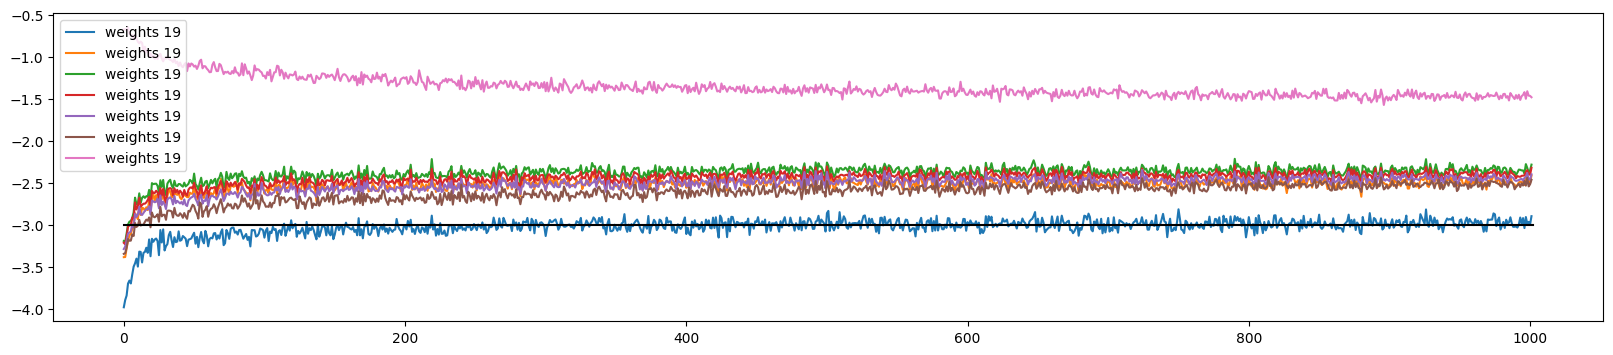

In [271]:
plt.figure(figsize=(20, 4))
legends = []

with torch.no_grad():
    # Alternatively we can call detach on hx and hy
    # Iterate over all tanh activation layers
    for idx, param in enumerate(parameters):
        grad = param.grad
        # only plot the weights, which are 2 dimensional
        if param.ndim == 2:
            plt.plot([update_to_data_ratio[k][idx] for k in range(len(update_to_data_ratio))])
            legends.append(f"weights {i}")
# If ratios are below ~1e-3 this means they are not learning fast enough, the lr is
# too small.
plt.plot([0, len(update_to_data_ratio)], [-3, -3], 'k') # these ratios should be ~1e-3,
plt.legend(legends)